In [1]:
# Import necessary resources
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams['figure.figsize'] = [14, 14]

In [2]:
class MLP(nn.Module):

    def __init__(self,dim=1,n=64):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(1, n)
        self.fc_2 = nn.Linear(n, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        out = self.sigmoid(self.fc_1(input))
        out = self.fc_2(out)

        return out

In [3]:
def example_1_and_2_loss(neural_network, a, g, ic, domain_lower_bound=0, domain_upper_bound=1, num_points=10):

    def trial_solution(x):
        result = ic + x * neural_network(x)

        return result
    
    delta = 1e-5
    x = torch.linspace(domain_lower_bound, domain_upper_bound, num_points, requires_grad=True).unsqueeze(1)
    dtrial_dx = (trial_solution(x+delta) - trial_solution(x)) / delta
    individual_error = (dtrial_dx - (g(x) - a(x)*trial_solution(x)))**2

    return torch.sum(individual_error)

def example_3_loss(neural_network, a, b, g, ic, ic_prime, domain_lower_bound=0, domain_upper_bound=1, num_points=10):
    """Computes loss for a given NN

    Parameters
    ----------
    nerual_network : torch.nn.Module
        Neural network used in trial solution
    a: function
        Function of coefficient in first-order linear DE
    b: function
        Function of coefficient in first-order linear DE
    g : function
        Function on right-hand side of DE
    ic : float
        Initial condition of DE solution
    ic_prime : float
        Initial condition on the derivative of DE solution
    domain_lower_bout : float, optional
        Lower limit of the DE domain considered
    domain_upper_bound : float, optional
        Upper limit of the DE domain considered
    num_points : int, optional
        Number of points in which to split the domain
    
    Returns
    -------
    torch.tensor
        resulting loss of trial solution in it's current state
    """

    def trial_solution(x):
        result = ic + x*ic_prime + (x**2) * neural_network(x)
        # print(result.requires_grad)
        return result
    
    delta = 1e-3
    x = torch.linspace(domain_lower_bound, domain_upper_bound, num_points, requires_grad=True).unsqueeze(1)
    dtrial_dx = (trial_solution(x+delta) - trial_solution(x)) / delta
    d2trial_dx2 = (trial_solution(x+delta) - 2*trial_solution(x) + trial_solution(x-delta))/(delta**2)
    individual_error = (d2trial_dx2 - (g(x) - a(x)*dtrial_dx - b(x)*trial_solution(x)))**2
    
    return torch.sum(individual_error)


## Example I
Consider the first-order ODE:
\begin{align}
\frac{d}{dx}\Psi + (x+\frac{1 + 3 x^2}{1 + x+ x^3})\Psi = x^3 + 2x +x^2\frac{1 + 3x^2}{1 + x + x^3},\quad \Psi(0) = 1 \quad and \quad x\in [0,1]
\end{align}
Solve for $\Psi(x)$


### Step 1: Define DE and Initial Condition

In [4]:
# Define Differential Equation
# Initial condition
f_0 = 1

# differential equation
def g(x):
    return x**3 + 2*x + (x**2)*((1+3*x**2)/(1+x+x**3))

def p(x):
    return x + ((1+3*(x**2))/(1+x+x**3))

### Step 2: Train the NN

In [5]:
learning_rate = 0.0005
epochs = 10000
display_step = 100

# Define NN
N = MLP()

# Create optimizer
optimizer = optim.Adam(N.parameters(), lr=learning_rate)

# Run the training steps
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute the loss
    loss = example_1_and_2_loss(N, p, g, f_0)
    
    # Backpropagate
    loss.backward()
    
    # Adjust model parameters accordingly
    optimizer.step()
    
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 13.064077377319336
epoch: 100, loss: 5.160963535308838
epoch: 200, loss: 3.703702449798584
epoch: 300, loss: 2.387665033340454
epoch: 400, loss: 1.3399165868759155
epoch: 500, loss: 0.6568026542663574
epoch: 600, loss: 0.2939983308315277
epoch: 700, loss: 0.1582866758108139
epoch: 800, loss: 0.09674134105443954
epoch: 900, loss: 0.08112557977437973
epoch: 1000, loss: 0.07845987379550934
epoch: 1100, loss: 0.07027988880872726
epoch: 1200, loss: 0.068505197763443
epoch: 1300, loss: 0.06808963418006897
epoch: 1400, loss: 0.06799101084470749
epoch: 1500, loss: 0.06473679840564728
epoch: 1600, loss: 0.06702537834644318
epoch: 1700, loss: 0.05994858965277672
epoch: 1800, loss: 0.05613935738801956
epoch: 1900, loss: 0.052820540964603424
epoch: 2000, loss: 0.053463879972696304
epoch: 2100, loss: 0.051110897213220596
epoch: 2200, loss: 0.04415411129593849
epoch: 2300, loss: 0.0460580550134182
epoch: 2400, loss: 0.04286539554595947
epoch: 2500, loss: 0.03986900672316551
epoch: 26

### Step 3: Visualize Result

Solving the DE by hand gives the exact result of $\Psi_a(x) = \frac{e^{\frac{-x^2}{2}}}{1+x+x^3} + x^2$. We will plot this against the trained trial solution.

Text(0, 0.5, 'Error')

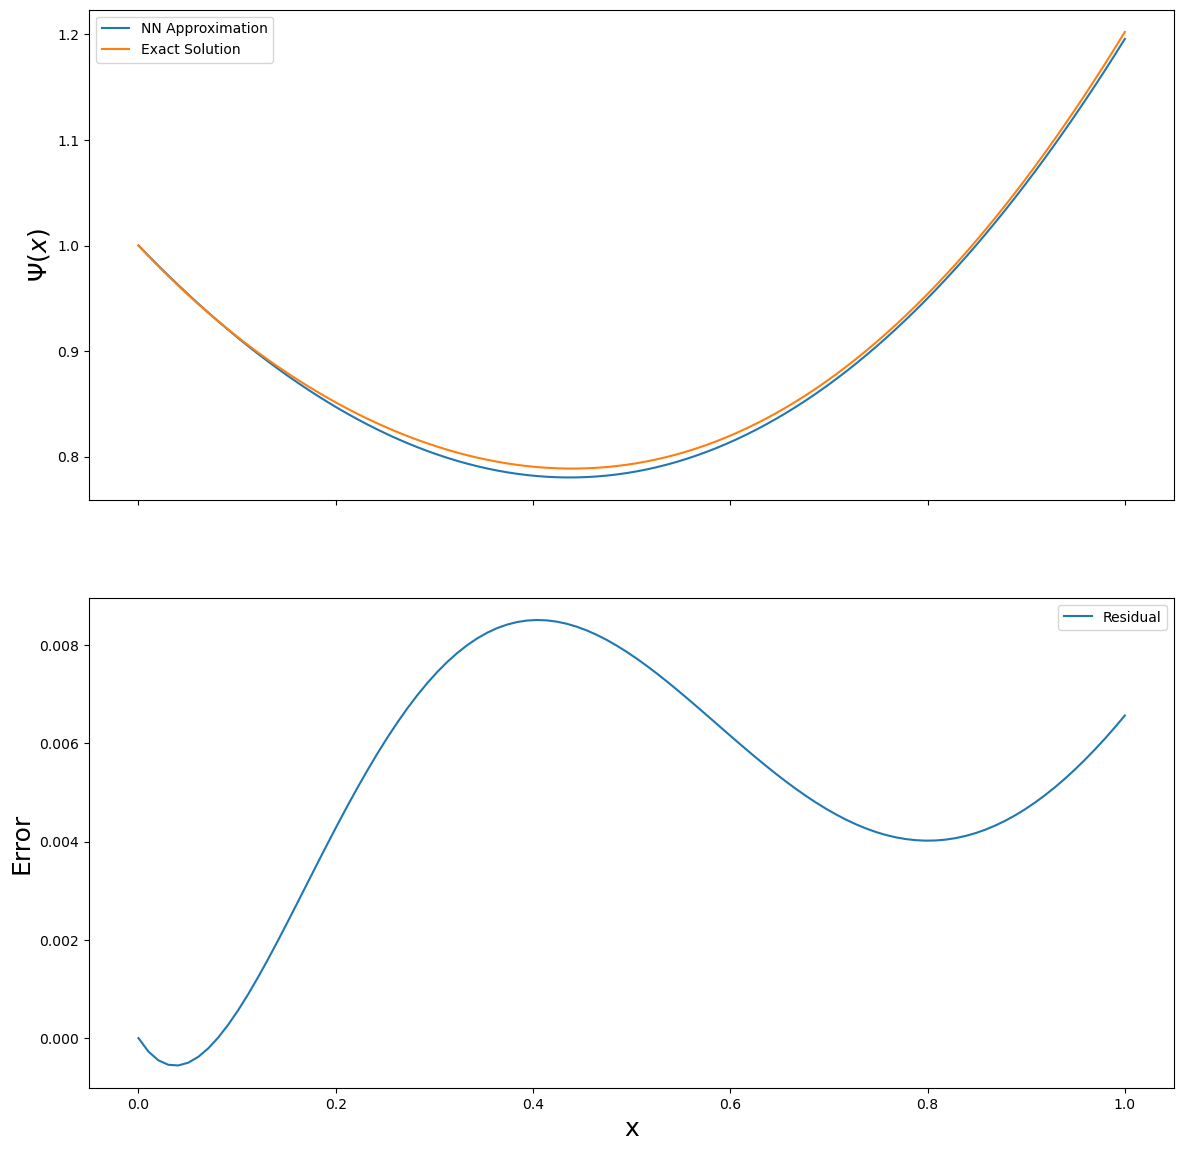

In [6]:
# Calculate 
x = torch.linspace(0, 1, 100, requires_grad=True).unsqueeze(1)
y_approx = (f_0 + x * N(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = ((torch.exp(-(x**2)/2)/(1+x+x**3))+x**2).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Plot the analytical solution with the approximation
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()

# Plot the residual
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)

## Example II: More Complicated
Consider the first-order ODE:
\begin{align}
\frac{d}{dx}\Psi + \frac{1}{5}\Psi = e^{-\frac{x}{5}}cos(x),\quad \Psi(0) = 0 \quad and \quad x\in [0,10]
\end{align}
Solve for $\Psi(x)$

### Step 1: Define DE and Initial Condition

In [7]:
# Define sample problem
# Initial condition
f_0 = 0

# differential equation
def g(x):
    return torch.exp(-x/5)*torch.cos(x)

def p(x):
    return 1/5


### Step 2: Train the NN

In [11]:
learning_rate = 0.008
epochs = 400
display_step = 500

# Define NN
N = MLP()

# Create optimizer
optimizer = optim.Adam(N.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = example_1_and_2_loss(N, p, g, f_0, 0, 6, 20)
    loss.backward()
    optimizer.step()
    # print(loss.item())
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 4.58361291885376


### Step 3: Visualize Result

Solving the DE by hand gives the exact result of $\Psi_a(x) = e^{-\frac{x}{5}}sin(x)$. We will plot this against the trained trial solution.

Text(0, 0.5, 'Error')

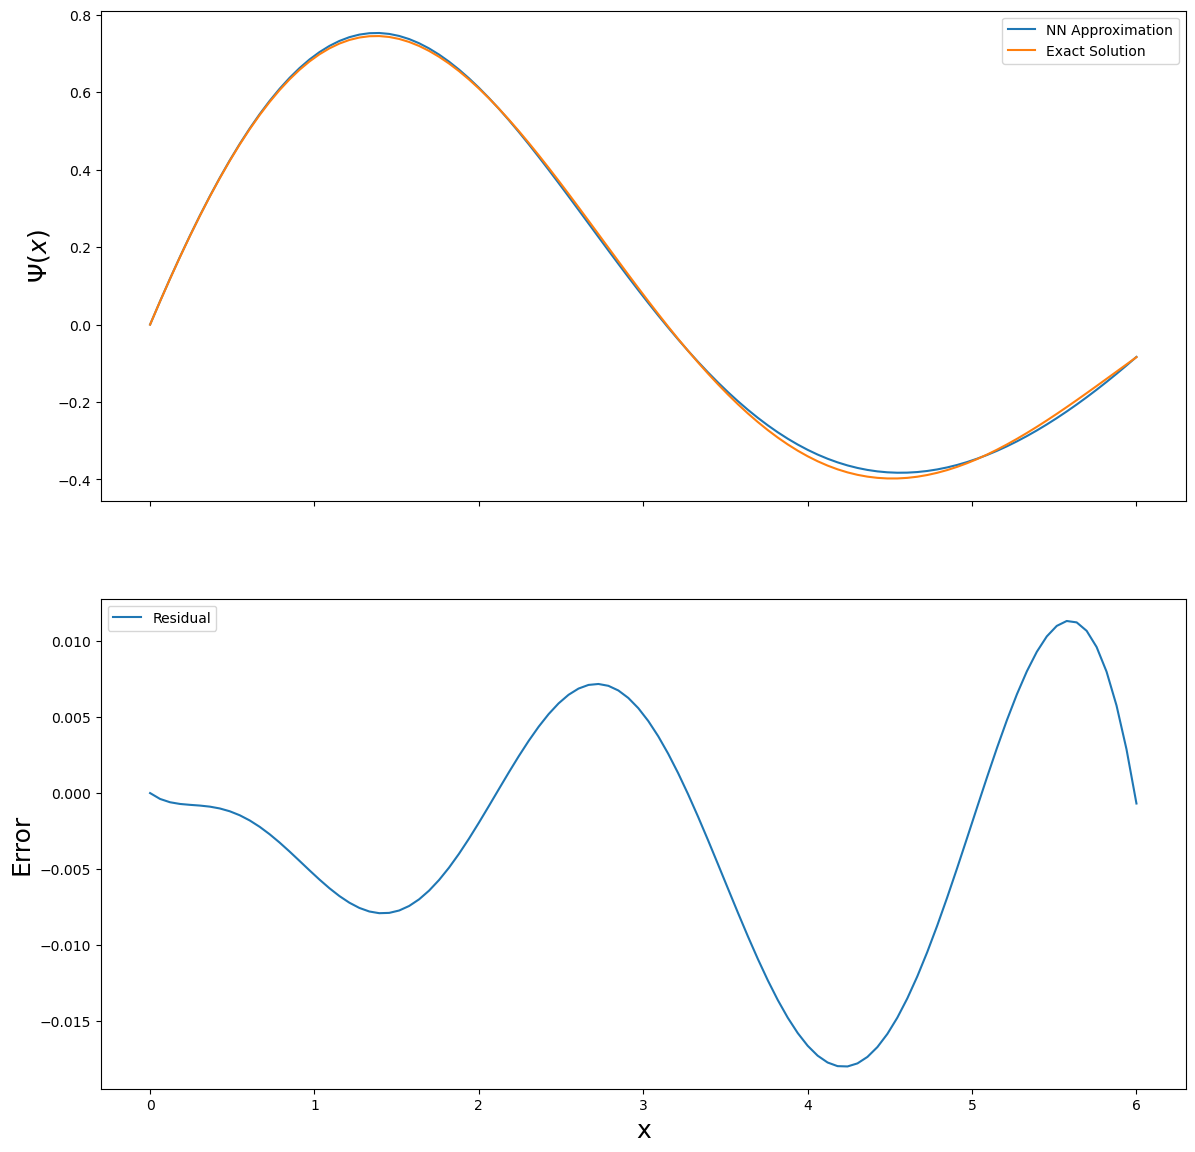

In [12]:
x = torch.linspace(0, 6, 100, requires_grad=True).unsqueeze(1)
y_approx = (f_0 + x * N(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = (torch.exp(-x/5)*torch.sin(x)).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)

# Second-Order ODEs

Note that a second-order ODE must be able to be written in the form 

\begin{align}
\frac{d^2}{dx^2}\Psi + a(x)\frac{d}{dx}\Psi + b(x)\Psi = g(x)
\end{align}

Where $a(x)$, $b(x)$, and $g(x)$ are continuous functions.

## Example III
The method described will be used to approximate the solution $\Psi(x)$ to the following second-order ODE:

\begin{align}
\frac{d^2}{dx^2}\Psi + \frac{1}{5}\frac{d}{dx}\Psi + \Psi= -\frac{1}{5}e^{-\frac{x}{5}}cos(x), \quad \Psi(0) = 0, \; \frac{d}{dx}\Psi(0)=1 \quad over \quad x\in [0,2]
\end{align}

In [13]:
# Define sample problem
# Initial condition
f_0 = 0
f_prime_0 = 1

# differential equation
def g(x):
    result = -(1.0/5.0)*torch.ones_like(x, requires_grad=True)*torch.exp(-x/5.0)*torch.cos(x)
#     print(result.requires_grad)
    return result

def a(x):
    result =(1.0/5.0)*torch.ones_like(x, requires_grad=True)
#     print(result.requires_grad)
    return result

def b(x):
    return torch.ones_like(x, requires_grad=True)

domain = (0, 2)

In [28]:
learning_rate = 0.003
epochs = 2000
display_step = 100

# Define NN
N = MLP(n=32)

# Create optimizer
optimizer = optim.Adam(N.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = example_3_loss(N, a, b, g, f_0, f_prime_0, domain[0], domain[1], 9)
    loss.backward()
    optimizer.step()
    
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 79.1535873413086
epoch: 100, loss: 0.29999008774757385
epoch: 200, loss: 0.12273672223091125
epoch: 300, loss: 0.20699544250965118
epoch: 400, loss: 0.11323317885398865
epoch: 500, loss: 0.14602315425872803
epoch: 600, loss: 0.05874316021800041
epoch: 700, loss: 0.6345396637916565
epoch: 800, loss: 0.13861483335494995
epoch: 900, loss: 0.12194159626960754
epoch: 1000, loss: 0.12736034393310547
epoch: 1100, loss: 0.03659063205122948
epoch: 1200, loss: 0.3097071051597595
epoch: 1300, loss: 0.19699913263320923
epoch: 1400, loss: 0.09481856226921082
epoch: 1500, loss: 0.0574674978852272
epoch: 1600, loss: 0.1390097290277481
epoch: 1700, loss: 0.11462616920471191
epoch: 1800, loss: 0.25548428297042847
epoch: 1900, loss: 0.11794407665729523


Text(0, 0.5, 'Error')

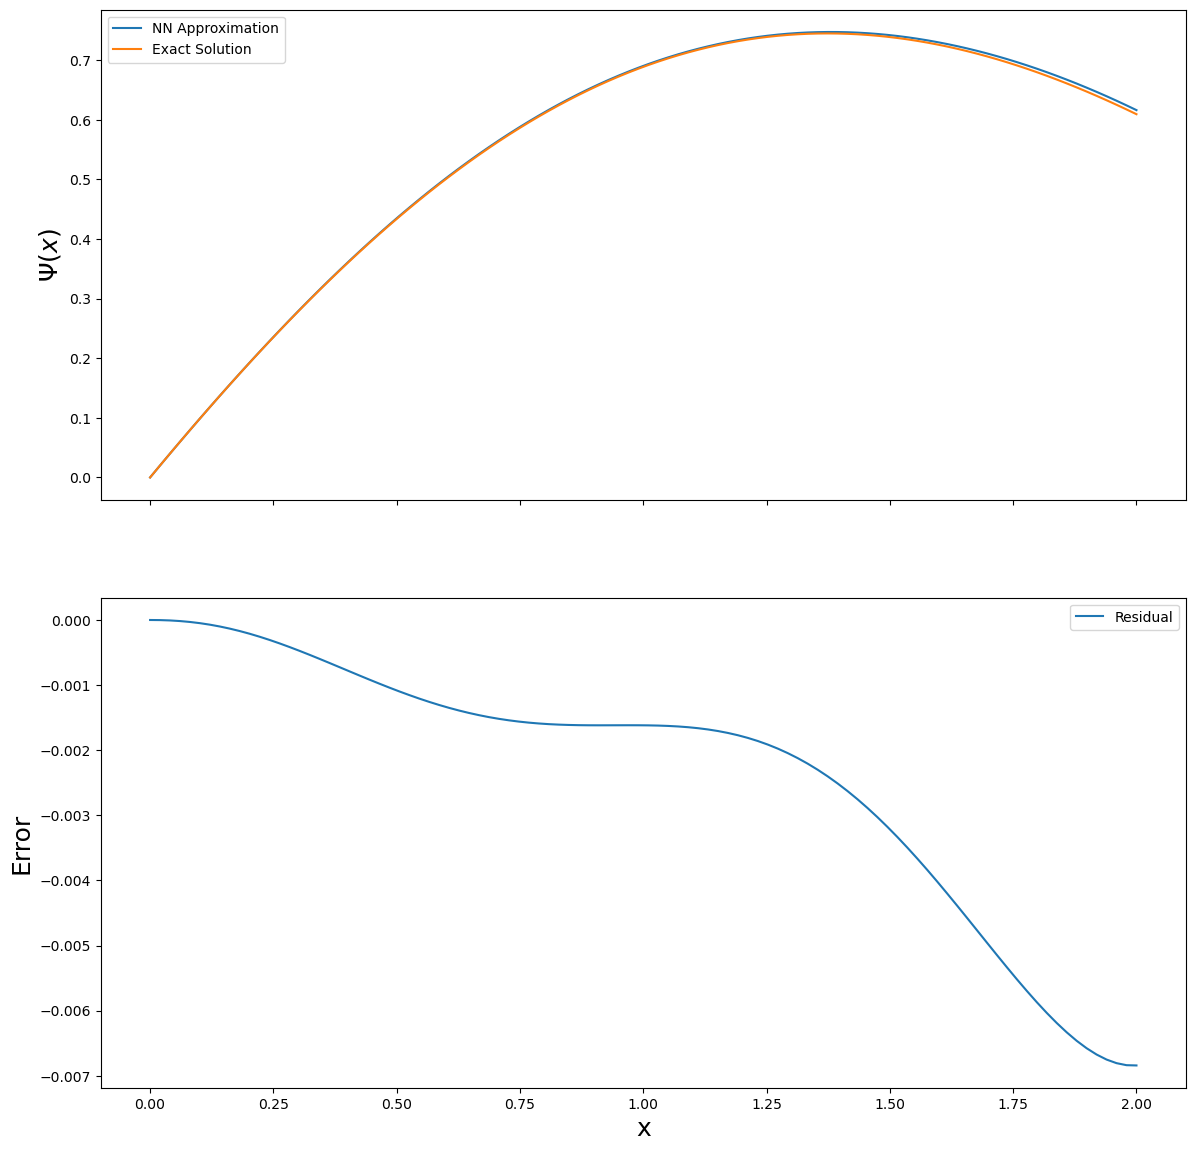

In [29]:
x = torch.linspace(domain[0], domain[1], 100, requires_grad=True).unsqueeze(1)
y_approx = (f_0 + x*f_prime_0 + x**2 * N(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = (torch.exp(-x/5)*torch.sin(x)).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)

In [31]:
def example_4_loss(N1,N2,domain_lower_bound=0, domain_upper_bound=3, num_points=100):
    """Computes loss for a given NN

    Parameters
    ----------
    nerual_network : torch.nn.Module
        Neural network used in trial solution
    a: function
        Function of coefficient in first-order linear DE
    g : function
        Function on right-hand side of DE
    ic : float
        Initial condition of DE
    domain_lower_bout : float, optional
        Lower limit of the DE domain considered
    domain_upper_bound : float, optional
        Upper limit of the DE domain considered
    num_points : int, optional
        Number of points in which to split the domain
    
    Returns
    -------
    torch.tensor
        resulting loss of trial solution in it's current state
    """
    # f1(0)=0
    def trial_solution1(x):
        result = 0 + x * N1(x)

        return result
    # f1(0)=1  
    def trial_solution2(x):
        result = 1 + x * N2(x)

        return result
    
    delta = 1e-5
    x = torch.linspace(domain_lower_bound, domain_upper_bound, num_points, requires_grad=True).unsqueeze(1)
    dtrial1_dx = (trial_solution1(x+delta) - trial_solution1(x)) / delta
    dtrial2_dx = (trial_solution2(x+delta) - trial_solution2(x)) / delta
    individual_error = (dtrial1_dx - (torch.cos(x)+trial_solution1(x)**2+trial_solution2(x)-(1+x**2+torch.sin(x)**2)))**2 + (dtrial2_dx - (2*x-(1+x**2)*torch.sin(x)+trial_solution1(x)*trial_solution2(x)))**2
    # individual_error = torch.abs(dtrial_dx - (g(x) - p(x)*trial_solution(x)))

    return torch.sum(individual_error)

In [32]:
lr1 = 0.01
lr2=0.03
epochs = 2000
display_step = 100

# Define N
N1 = MLP(n=64)
N2 = MLP(n=64)

# Create optimizer
optimizer1 = optim.Adam(N1.parameters(), lr=lr1)
optimizer2 = optim.Adam(N2.parameters(), lr=lr2)

# Run the training steps
for epoch in range(epochs):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    
    # Compute the loss
    loss = example_4_loss(N1,N2)
    
    # Backpropagate
    loss.backward()
    
    # Adjust model parameters accordingly
    optimizer1.step()
    optimizer2.step()
    
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 2141.544921875
epoch: 100, loss: 9.205399513244629
epoch: 200, loss: 5.588680267333984
epoch: 300, loss: 3.271289825439453
epoch: 400, loss: 2.2551839351654053
epoch: 500, loss: 1.5885814428329468
epoch: 600, loss: 1.2055481672286987
epoch: 700, loss: 2.613034963607788
epoch: 800, loss: 1.3015775680541992
epoch: 900, loss: 0.7778236865997314
epoch: 1000, loss: 0.866085410118103
epoch: 1100, loss: 0.4909861981868744
epoch: 1200, loss: 2.1560208797454834
epoch: 1300, loss: 3.1265549659729004
epoch: 1400, loss: 8.24338436126709
epoch: 1500, loss: 0.7089421153068542
epoch: 1600, loss: 0.3696238398551941
epoch: 1700, loss: 0.7469866275787354
epoch: 1800, loss: 0.44318121671676636
epoch: 1900, loss: 1.0044422149658203


Text(0, 0.5, 'Error')

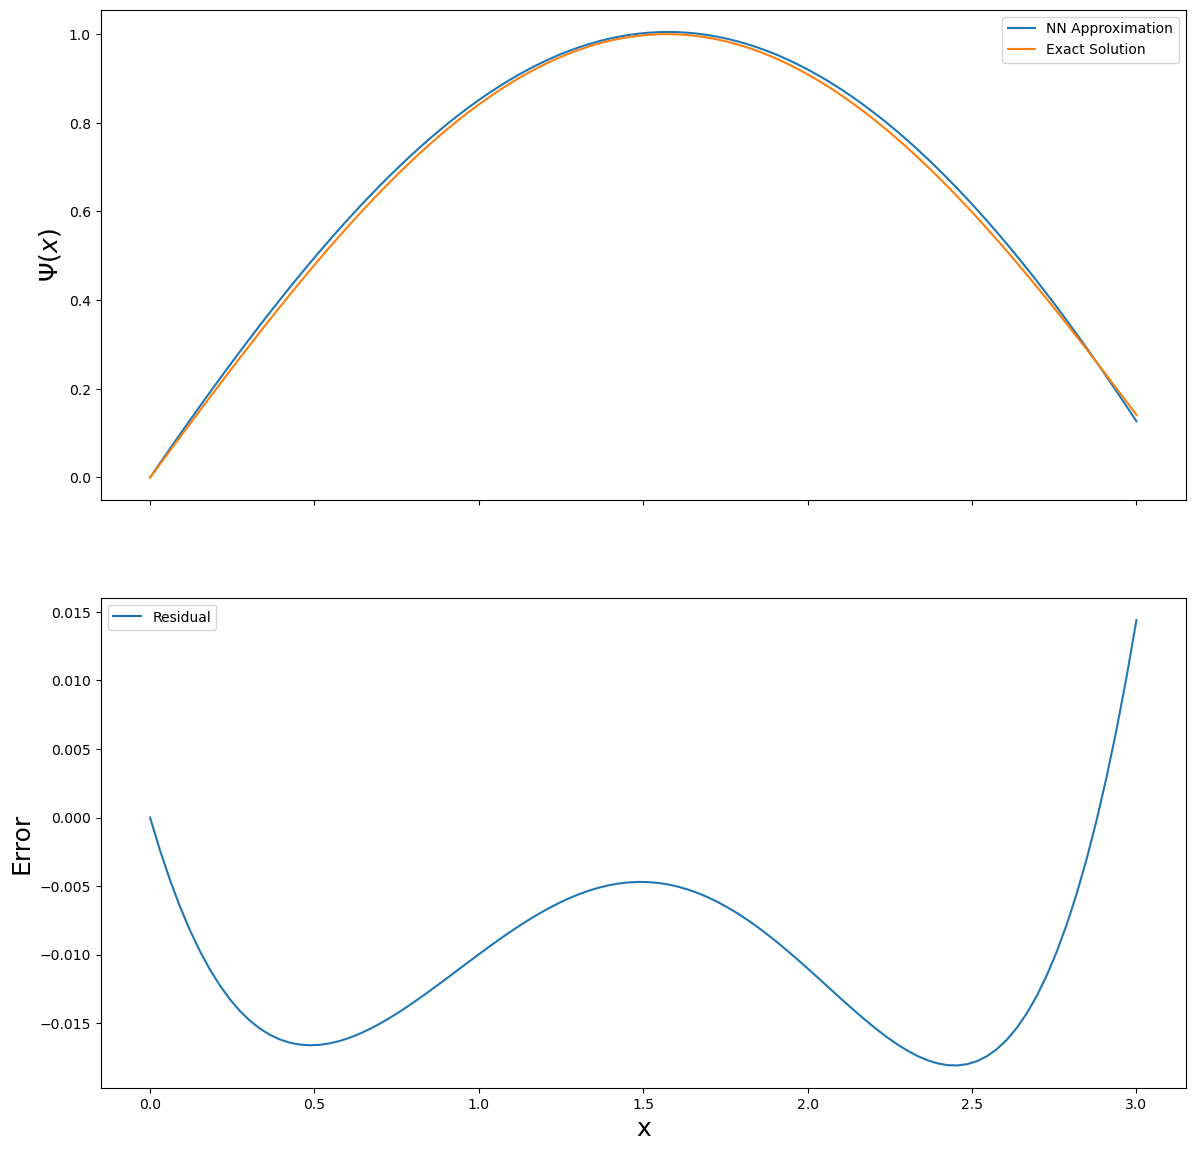

In [33]:
# Calculate 
x = torch.linspace(0, 3, 100, requires_grad=True).unsqueeze(1)
y_approx = (0 + x * N1(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = (torch.sin(x)).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Plot the analytical solution with the approximation
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()

# Plot the residual
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)

Text(0, 0.5, 'Error')

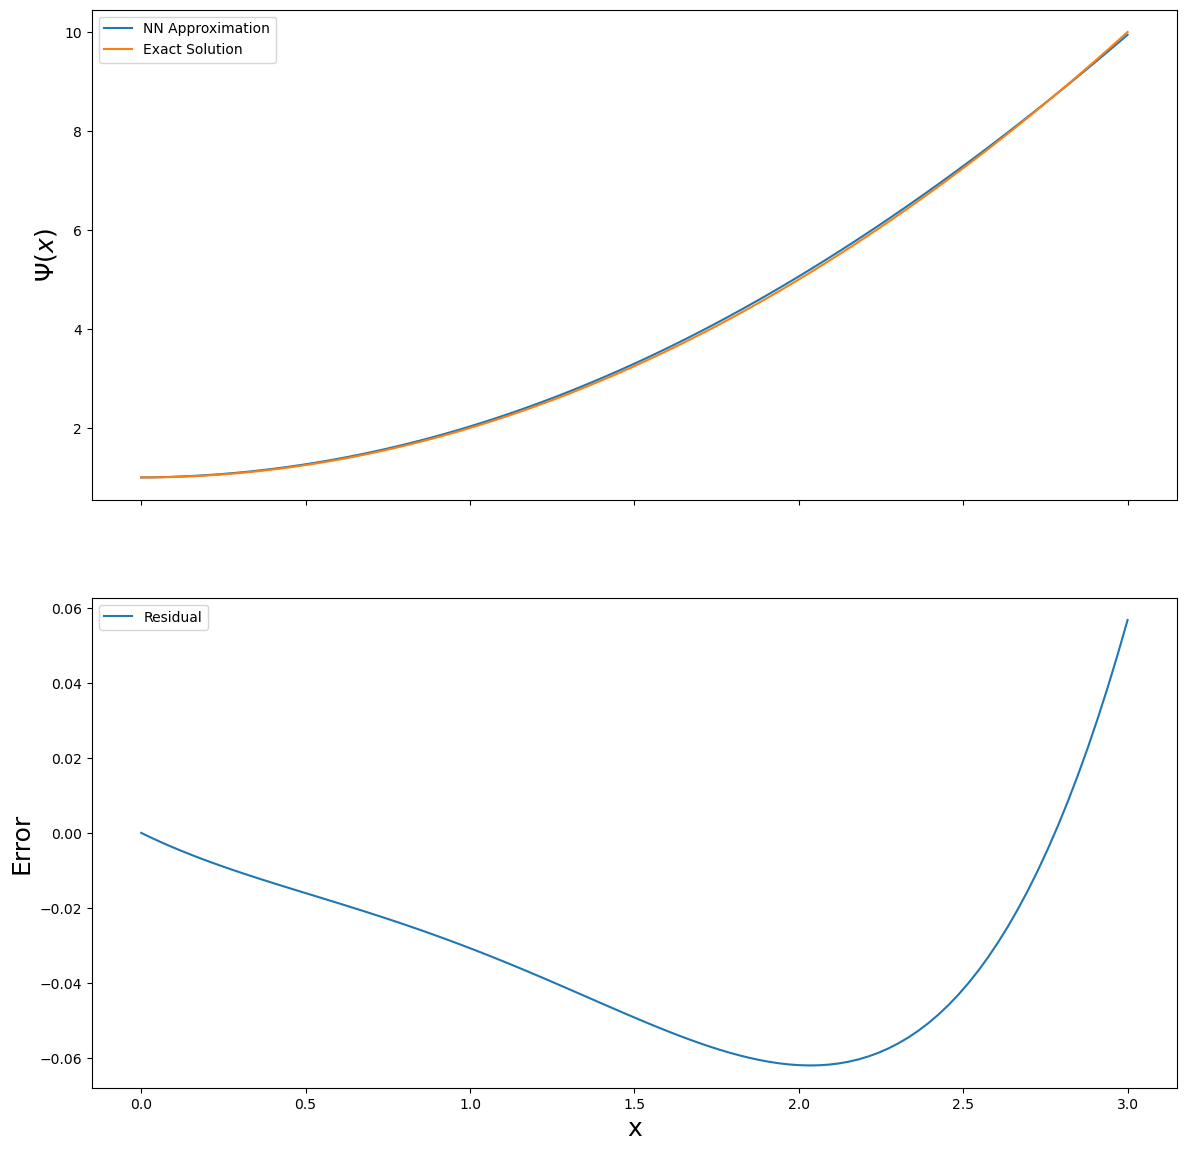

In [34]:
# Calculate 
x = torch.linspace(0, 3, 100, requires_grad=True).unsqueeze(1)
y_approx = (1 + x * N2(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = (1+x**2).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Plot the analytical solution with the approximation
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()

# Plot the residual
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)

In [35]:
class MLP2(nn.Module):

    def __init__(self,n=64):
        super(MLP2, self).__init__()
        self.fc_1 = nn.Linear(2, n)
        self.fc_2 = nn.Linear(n, 1)
        self.act = nn.Sigmoid()
    def forward(self,x,y):
        input=torch.stack([x,y],dim=-1)
        out = self.act(self.fc_1(input))
        out = self.fc_2(out)
        return out

In [36]:
def example_5_loss(N,x_domain_lower_bound=0, x_domain_upper_bound=1,y_domain_lower_bound=0, y_domain_upper_bound=1, num_points=10):
    """Computes loss for a given NN

    Parameters
    ----------
    nerual_network : torch.nn.Module
        Neural network used in trial solution
    a: function
        Function of coefficient in first-order linear DE
    g : function
        Function on right-hand side of DE
    ic : float
        Initial condition of DE
    domain_lower_bout : float, optional
        Lower limit of the DE domain considered
    domain_upper_bound : float, optional
        Upper limit of the DE domain considered
    num_points : int, optional
        Number of points in which to split the domain
    
    Returns
    -------
    torch.tensor
        resulting loss of trial solution in it's current state
    """
    def A(x, y):
        exp_neg_1 = torch.exp(torch.tensor(-1.0))
        result = (1 - x) * y**3 + x * (1 + y**3) * exp_neg_1 + (1 - y) * x * (torch.exp(-x) - exp_neg_1) + y * ((1 + x) * torch.exp(-x) - (1 - x + 2 * x * exp_neg_1))
        return result
        
    def trial_solution(x,y):
        result = A(x,y)+ x *(1-x)*y*(1-y)*N(x,y)
        return result

    h = 1e-2
     # Create a grid of x and y values using torch.meshgrid
    x_values = torch.linspace(x_domain_lower_bound, x_domain_upper_bound, num_points, requires_grad=True)
    y_values = torch.linspace(y_domain_lower_bound, y_domain_upper_bound, num_points, requires_grad=True)
    X, Y = torch.meshgrid(x_values, y_values, indexing='ij')

    # Flatten the grid to pass to the network
    X_flat = X.flatten().unsqueeze(1)
    Y_flat = Y.flatten().unsqueeze(1)

    # Compute the Laplacian using finite differences
    f_xx = (trial_solution(X_flat + h, Y_flat) - 2 * trial_solution(X_flat, Y_flat) + trial_solution(X_flat - h, Y_flat)) / h**2
    f_yy = (trial_solution(X_flat, Y_flat + h) - 2 * trial_solution(X_flat, Y_flat) + trial_solution(X_flat, Y_flat - h)) / h**2
    laplacian = f_xx + f_yy

    # Calculate the individual error at each grid point
    individual_error = (laplacian - torch.exp(-X_flat) * (X_flat - 2 + Y_flat**3 + 6 * Y_flat))**2
    
    # Sum the errors to get the total loss
    return torch.sum(individual_error)


In [41]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# Set learning rate and other parameters
lr = 0.005
epochs = 20000
display_step = 100

# Define NN
N = MLP2()

# Create optimizer
optimizer = optim.Adam(N.parameters(), lr=lr)

# Create the cosine annealing scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# Run the training steps
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute the loss
    loss = example_5_loss(N)
    
    # Backpropagate
    loss.backward()
    
    # Adjust model parameters accordingly
    optimizer.step()
    
    # Step the scheduler after each epoch
    scheduler.step()
    
    # Display progress
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}, lr: {}".format(epoch, loss.item(), scheduler.get_last_lr()[0]))


epoch: 0, loss: 569.8262329101562, lr: 0.004999999969157486
epoch: 100, loss: 83.60621643066406, lr: 0.004999685382116376
epoch: 200, loss: 83.50445556640625, lr: 0.004998754035110833
epoch: 300, loss: 83.41056060791016, lr: 0.004997206157936787
epoch: 400, loss: 83.294189453125, lr: 0.0049950421325097635
epoch: 500, loss: 83.20828247070312, lr: 0.004992262492770661
epoch: 600, loss: 83.11741638183594, lr: 0.004988867924554
epoch: 700, loss: 83.01705169677734, lr: 0.00498485926541868
epoch: 800, loss: 82.94803619384766, lr: 0.0049802375044413665
epoch: 900, loss: 82.85973358154297, lr: 0.004975003781972417
epoch: 1000, loss: 82.81552124023438, lr: 0.004969159389354547
epoch: 1100, loss: 82.71763610839844, lr: 0.004962705768604176
epoch: 1200, loss: 82.63727569580078, lr: 0.004955644512055662
epoch: 1300, loss: 82.55622863769531, lr: 0.00494797736196839
epoch: 1400, loss: 82.36888122558594, lr: 0.0049397062100969245
epoch: 1500, loss: 81.86993408203125, lr: 0.00493083309722423
epoch: 16

(100, 100)
tensor(0.)
(100, 100)


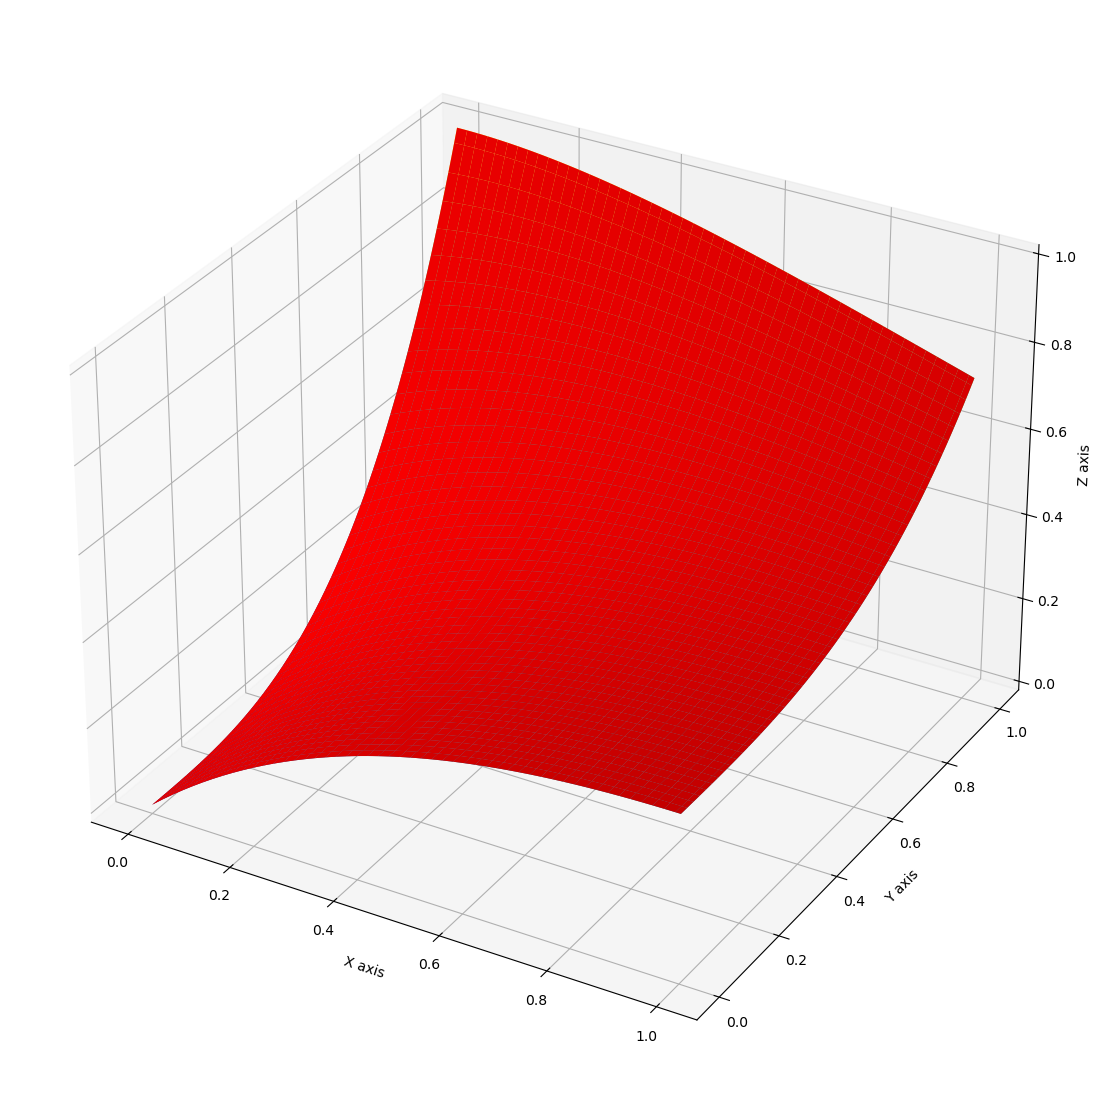

In [42]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
# print(x, y)

# # Compute z values based on the function z = e^(-x(x + y^3))
z = np.exp(-x)*((x + y**3))
print(z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
print((xy_pairs[0][0]))
def trial_solution(inp):
    x = inp[:, 0]
    y = inp[:, 1]
    result = (1-x)*(y**3) + x*(1+y**3)*torch.exp(torch.tensor(-1)) + (1-y)*x*(torch.exp(-x) - torch.exp(torch.tensor(-1))) + y*((1+x)*torch.exp(-x) - (1-x + 2*x*torch.exp(torch.tensor(-1)))) + x*(1-x)*y*(1-y)*(N(x,y).squeeze())
    return result
z_trial = trial_solution(xy_pairs).detach().numpy().reshape(100,100)
print(z_trial.shape)

ax.plot_surface(x, y, z_trial, color='red')
# # Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

(100, 100)
tensor(0.)
Maximum abs error: 0.0007746898421651105
(100, 100)


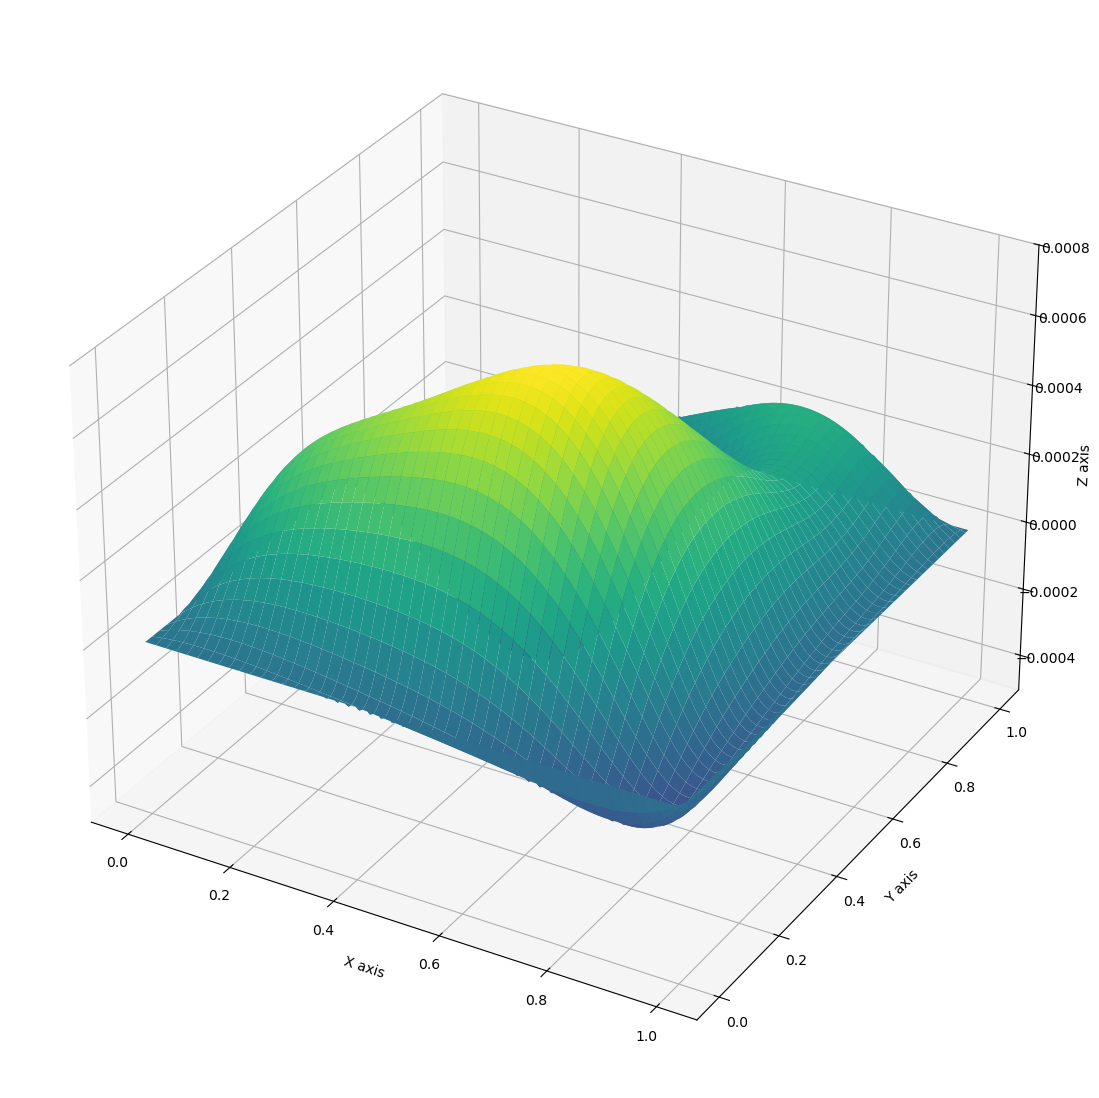

In [43]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
# print(x, y)

# # Compute z values based on the function z = e^(-x(x + y^3))
z = np.exp(-x)*((x + y**3))
print(z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
print((xy_pairs[0][0]))
def trial_solution(inp):
    x = inp[:, 0]
    y = inp[:, 1]
    result = (1-x)*(y**3) + x*(1+y**3)*torch.exp(torch.tensor(-1)) + (1-y)*x*(torch.exp(-x) - torch.exp(torch.tensor(-1))) + y*((1+x)*torch.exp(-x) - (1-x + 2*x*torch.exp(torch.tensor(-1)))) + x*(1-x)*y*(1-y)*(N(x,y).squeeze())
    return result
z_trial = trial_solution(xy_pairs).detach().numpy().reshape(100,100)
print(f"Maximum abs error: {np.max((z_trial-z))}")
print(z_trial.shape)

ax.plot_surface(x, y, (z_trial-z), cmap='viridis')
# # Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [44]:
def example_6_loss(N,x_domain_lower_bound=0, x_domain_upper_bound=1,y_domain_lower_bound=0, y_domain_upper_bound=1, num_points=10):
    """Computes loss for a given N

    Parameters
    ----------
    nerual_network : torch.N.Module
        Neural network used in trial solution
    a: function
        Function of coefficient in first-order linear DE
    g : function
        Function on right-hand side of DE
    ic : float
        Initial condition of DE
    domain_lower_bout : float, optional
        Lower limit of the DE domain considered
    domain_upper_bound : float, optional
        Upper limit of the DE domain considered
    num_points : int, optional
        Number of points in which to split the domain
    
    Returns
    -------
    torch.tensor
        resulting loss of trial solution in it's current state
    """
    h = 1e-2
     # Create a grid of x and y values using torch.meshgrid
    x_values = torch.linspace(x_domain_lower_bound, x_domain_upper_bound, num_points, requires_grad=True)
    y_values = torch.linspace(y_domain_lower_bound, y_domain_upper_bound, num_points, requires_grad=True)
    X, Y = torch.meshgrid(x_values, y_values, indexing='ij')

    # Flatten the grid to pass to the network
    X_flat = X.flatten()
    Y_flat = Y.flatten()

    # Define the function B(x, y)
    def B(x, y):
        result = 2 * y * torch.sin(torch.pi * x)
        return result

    # Compute the derivative of the neural network with respect to y
    dN_dy = lambda x, y: (N(x, y + 1e-3) - N(x, y)) / 1e-3

    # Define the trial solution using the neural network and B(x, y)
    def trial_solution(x, y):
        result = B(x, y).squeeze() + x * (1 - x) * y * (N(x, y).squeeze() - N(x, torch.ones_like(y)).squeeze() - dN_dy(x, torch.ones_like(y)).squeeze())
        return result

    # Compute the Laplacian using finite differences
    f_xx = (trial_solution(X_flat + h, Y_flat) - 2 * trial_solution(X_flat, Y_flat) + trial_solution(X_flat - h, Y_flat)) / h**2
    f_yy = (trial_solution(X_flat, Y_flat + h) - 2 * trial_solution(X_flat, Y_flat) + trial_solution(X_flat, Y_flat - h)) / h**2
    laplacian = f_xx + f_yy

    # Calculate the individual error at each grid point
    individual_error = (laplacian - torch.sin(torch.pi * X_flat) * (2 - (torch.pi**2) * (Y_flat**2)))**2

    # Sum the errors to get the total loss
    return torch.sum(individual_error)

In [45]:
lr = 0.007
epochs = 2000
display_step = 100

# Define NN
N = MLP2(n=64)

# Create optimizer
optimizer = optim.Adam(N.parameters(), lr=lr)

# Run the training steps
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute the loss
    loss = example_6_loss(N)
    
    # Backpropagate
    loss.backward()
    
    # Adjust model parameters accordingly
    optimizer.step()
    
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 3703.70947265625
epoch: 100, loss: 701.8345947265625
epoch: 200, loss: 424.6449279785156
epoch: 300, loss: 78.782958984375
epoch: 400, loss: 51.124114990234375
epoch: 500, loss: 60.937217712402344
epoch: 600, loss: 66.48673248291016
epoch: 700, loss: 46.61681365966797
epoch: 800, loss: 40.636444091796875
epoch: 900, loss: 73.28358459472656
epoch: 1000, loss: 21.444477081298828
epoch: 1100, loss: 80.44429016113281
epoch: 1200, loss: 37.166202545166016
epoch: 1300, loss: 23.788375854492188
epoch: 1400, loss: 40.146854400634766
epoch: 1500, loss: 40.51091003417969
epoch: 1600, loss: 56.9848518371582
epoch: 1700, loss: 57.5859375
epoch: 1800, loss: 58.56690216064453
epoch: 1900, loss: 59.36717224121094


(100, 100)
Maximum ABS error: 0.02672927725791463
(100, 100)
(100, 100)


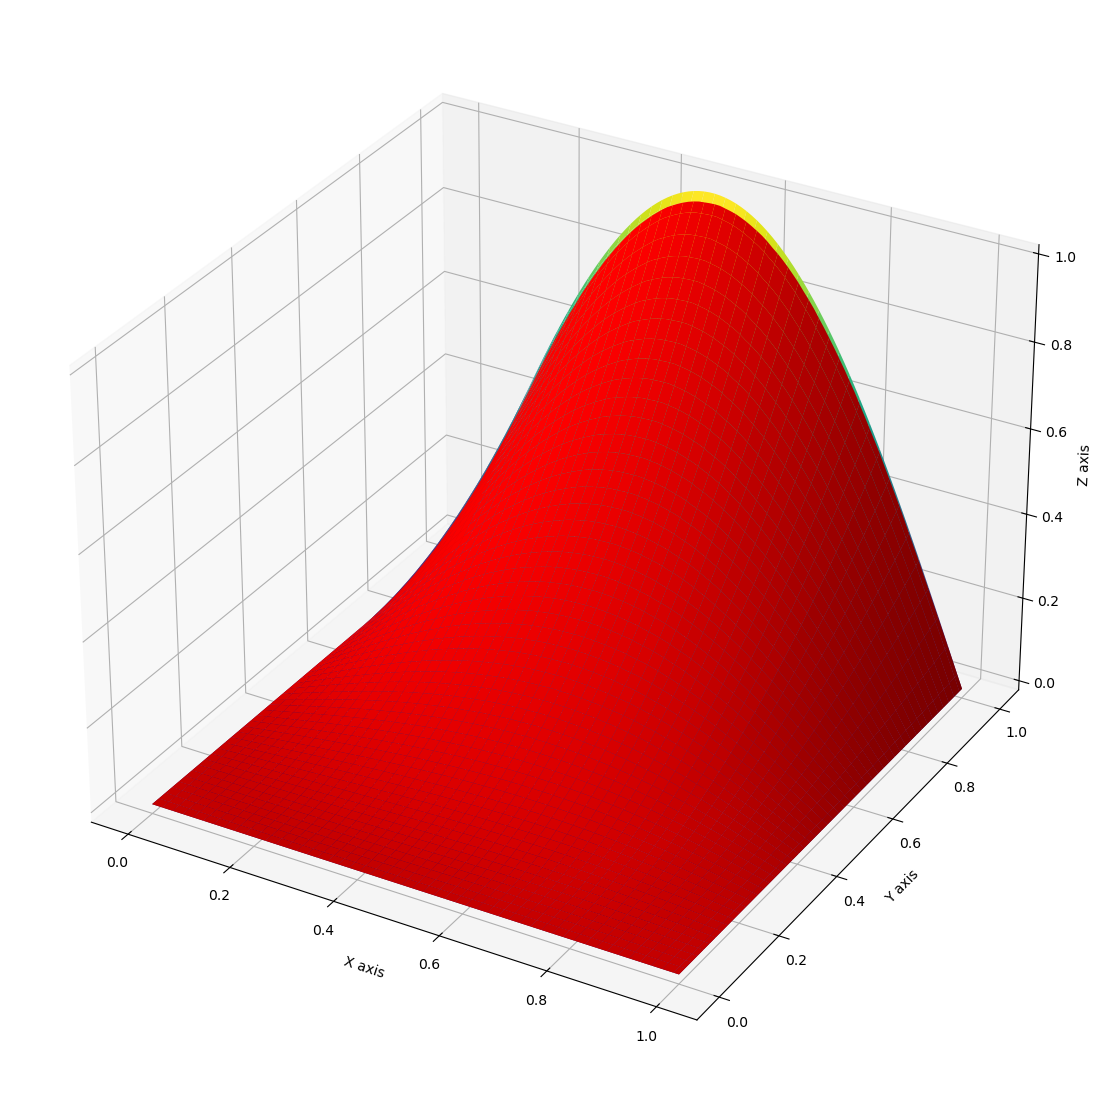

In [46]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
# print(x, y)

z = y**2 * np.sin(np.pi*x)
print(z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
# print((xy_pairs[0][0]))
h = 1e-3
dN_dy=lambda x,y:(N(x,y+1e-4)-N(x,y))/1e-4
x1 = xy_pairs[:, 0]
y1 = xy_pairs[:, 1]
def B(x, y):
    result = 2*y*torch.sin(torch.pi*x)
    return result
        
def trial_solution(x,y):
    result = B(x,y).squeeze()+ x *(1-x)*y*(N(x,y).squeeze()-N(x,torch.ones(y.shape)).squeeze()-dN_dy(x,torch.ones(y.shape)).squeeze())
    return result
z_trial = trial_solution(x1,y1).detach().numpy().reshape(100,100)
print(f"Maximum ABS error: {np.max(np.abs(z_trial-z))}")
print(z_trial.shape)
print(z.shape)

ax.plot_surface(x, y, z_trial, color='red')
# # Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

(100, 100)
Maximum ABS error: 0.02672927725791463
(100, 100)
(100, 100)


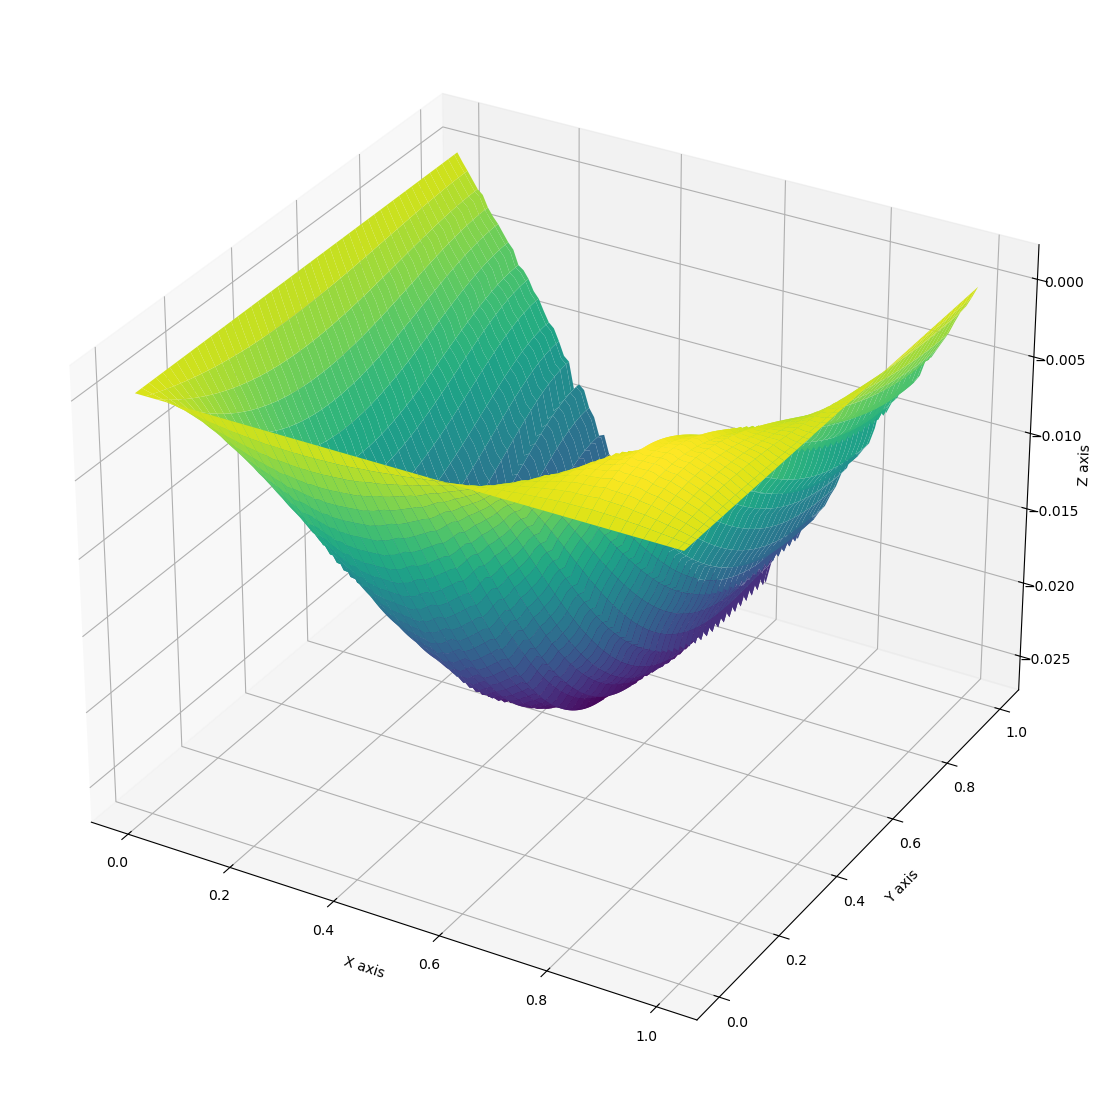

In [47]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
# print(x, y)

z = y**2 * np.sin(np.pi*x)
print(z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(x, y, z, cmap='viridis')

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
# print((xy_pairs[0][0]))
h = 1e-3
dN_dy=lambda x,y:(N(x,y+1e-4)-N(x,y))/1e-4
x1 = xy_pairs[:, 0]
y1 = xy_pairs[:, 1]
def B(x, y):
    result = 2*y*torch.sin(torch.pi*x)
    return result
        
def trial_solution(x,y):
    result = B(x,y).squeeze()+ x *(1-x)*y*(N(x,y).squeeze()-N(x,torch.ones(y.shape)).squeeze()-dN_dy(x,torch.ones(y.shape)).squeeze())
    return result
z_trial = trial_solution(x1,y1).detach().numpy().reshape(100,100)
print(f"Maximum ABS error: {np.max(np.abs(z_trial-z))}")
print(z_trial.shape)
print(z.shape)

ax.plot_surface(x, y, z_trial-z, cmap='viridis')
# # Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [48]:
def example_7_loss(N,x_domain_lower_bound=0, x_domain_upper_bound=1,y_domain_lower_bound=0, y_domain_upper_bound=1, num_points=10):
    """Computes loss for a given N

    Parameters
    ----------
    nerual_network : torch.N.Module
        Neural network used in trial solution
    a: function
        Function of coefficient in first-order linear DE
    g : function
        Function on right-hand side of DE
    ic : float
        Initial condition of DE
    domain_lower_bout : float, optional
        Lower limit of the DE domain considered
    domain_upper_bound : float, optional
        Upper limit of the DE domain considered
    num_points : int, optional
        Number of points in which to split the domain
    
    Returns
    -------
    torch.tensor
        resulting loss of trial solution in it's current state
    """
    h = 1e-2
     # Create a grid of x and y values using torch.meshgrid
    x_values = torch.linspace(x_domain_lower_bound, x_domain_upper_bound, num_points, requires_grad=True)
    y_values = torch.linspace(y_domain_lower_bound, y_domain_upper_bound, num_points, requires_grad=True)
    X, Y = torch.meshgrid(x_values, y_values, indexing='ij')

    # Flatten the grid to pass to the network
    X_flat = X.flatten()
    Y_flat = Y.flatten()

    # Define the function B(x, y)
    def B(x, y):
        result = 2 * y * torch.sin(torch.pi * x)
        return result

    # Compute the derivative of the neural network with respect to y
    dN_dy = lambda x, y: (N(x, y + 1e-3) - N(x, y)) / 1e-3

    # Define the trial solution using the neural network and B(x, y)
    def trial_solution(x, y):
        result = B(x, y).squeeze() + x * (1 - x) * y * (N(x, y).squeeze() - N(x, torch.ones_like(y)).squeeze() - dN_dy(x, torch.ones_like(y)).squeeze())
        return result

    # Compute the Laplacian using finite differences
    f_xx = (trial_solution(X_flat + h, Y_flat) - 2 * trial_solution(X_flat, Y_flat) + trial_solution(X_flat - h, Y_flat)) / h**2
    f_yy = (trial_solution(X_flat, Y_flat + h) - 2 * trial_solution(X_flat, Y_flat) + trial_solution(X_flat, Y_flat - h)) / h**2
    dtrial_dy=(trial_solution(X_flat,Y_flat+h)-trial_solution(X_flat,Y_flat))/h
    laplacian = f_xx + f_yy

    # Calculate the individual error at each grid point
    individual_error = (laplacian + trial_solution(X_flat, Y_flat)*dtrial_dy - torch.sin(torch.pi*X_flat)*(2-(torch.pi**2)*(Y_flat**2) + 2*Y_flat**3*torch.sin(torch.pi*X_flat)))**2

    # Sum the errors to get the total loss
    return torch.sum(individual_error)

In [49]:
lr = 0.005
epochs = 2000
display_step = 100


# Define N
N = MLP2(n=64)

# Create optimizer
optimizer = optim.Adam(N.parameters(), lr=lr)

# Run the training steps
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute the loss
    loss = example_7_loss(N)
    
    # Backpropagate
    loss.backward()
    
    # Adjust model parameters accordingly
    optimizer.step()
    
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 2586.756591796875
epoch: 100, loss: 653.8511352539062
epoch: 200, loss: 510.22119140625
epoch: 300, loss: 356.32843017578125
epoch: 400, loss: 72.87771606445312
epoch: 500, loss: 26.484663009643555
epoch: 600, loss: 38.60781478881836
epoch: 700, loss: 26.11786460876465
epoch: 800, loss: 31.79155921936035
epoch: 900, loss: 72.78228759765625
epoch: 1000, loss: 43.87411117553711
epoch: 1100, loss: 21.162921905517578
epoch: 1200, loss: 25.12774658203125
epoch: 1300, loss: 43.88426208496094
epoch: 1400, loss: 33.02968215942383
epoch: 1500, loss: 44.8135986328125
epoch: 1600, loss: 26.38304901123047
epoch: 1700, loss: 21.661046981811523
epoch: 1800, loss: 18.300525665283203
epoch: 1900, loss: 20.755300521850586


(100, 100)
torch.Size([10000, 1])
Maximum abs error: 0.010283793816878606


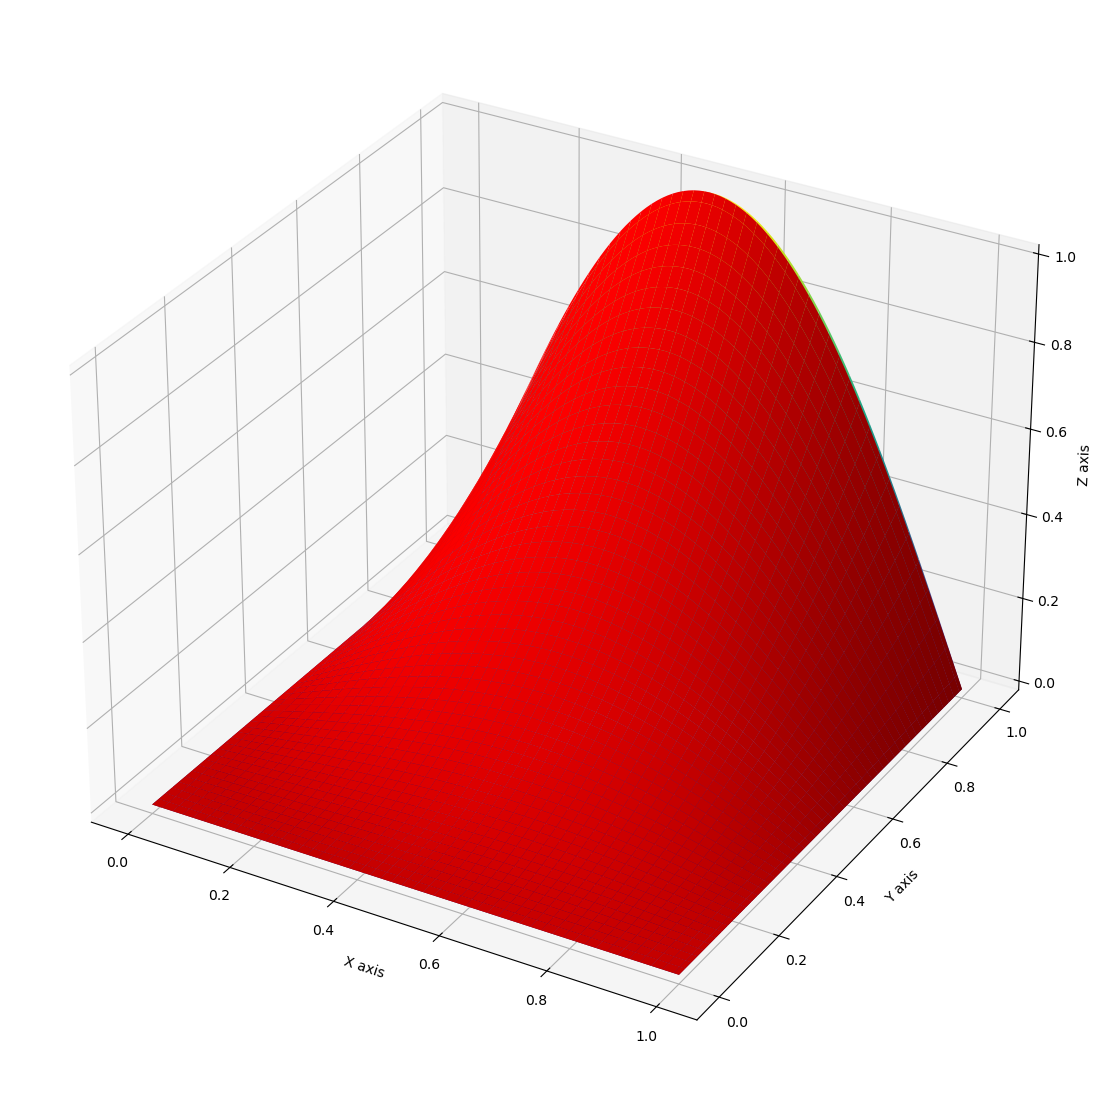

In [50]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
# print(x, y)

z = y**2 * np.sin(np.pi*x)
print(z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis')

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
# print((xy_pairs[0][0]))
h = 1e-3
dN_dy=lambda x,y:(N(x,y+h)-N(x,y))/h
def trial_solution(inp):
    x = inp[:, 0]
    y = inp[:, 1]
    print(N(x,y).shape)
    result = x *(1-x)*y*(N(x,y).squeeze()-N(x,torch.ones(y.shape)).squeeze()-dN_dy(x,torch.ones(y.shape)).squeeze()) + (2*y*(torch.sin(torch.pi*x))).squeeze()
    return result
z_trial = trial_solution(xy_pairs).detach().numpy().reshape(100,100)
print(f"Maximum abs error: {np.max(np.abs(z_trial-z))}")
# print(z_trial.shape)
# print(z.shape)

ax.plot_surface(x, y, z_trial, color='red')
# # Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [51]:
import numpy as np
import torch
import plotly.graph_objs as go

# Define the x and y grid
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)

# Define the z values
z = y**2 * np.sin(np.pi * x)

# Prepare input for the neural network (or any other function)
xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype=torch.float32)

h = 1e-3
# Define your neural network function N and its derivative dN_dy
# Here I'll assume N is a placeholder for your trained neural network model

dN_dy = lambda x, y: (N(x, y + h) - N(x, y)) / h

def trial_solution(inp):
    x = inp[:, 0]
    y = inp[:, 1]
    result = x * (1 - x) * y * (N(x, y).squeeze() - N(x, torch.ones(y.shape)).squeeze() - dN_dy(x, torch.ones(y.shape)).squeeze()) + (2 * y * torch.sin(torch.pi * x)).squeeze()
    return result

# Calculate the trial solution for the grid
z_trial = trial_solution(xy_pairs).detach().numpy().reshape(100, 100)

# Create an interactive 3D plot using plotly
fig = go.Figure()

# Add the original surface (z values)
fig.add_trace(go.Surface(z=z, x=x, y=y, colorscale='Viridis', name='Original Surface'))

# Add the trial solution surface
fig.add_trace(go.Surface(z=z_trial, x=x, y=y, colorscale='Reds', name='Trial Solution'))

# Update the layout for better visualization
fig.update_layout(
    title='3D Surface Plot',
    scene=dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
    width=1000,
    height=1000
)

# Display the plot
fig.show()


(100, 100)
Maximum ABS error: 0.010425663360215442
(100, 100)
(100, 100)


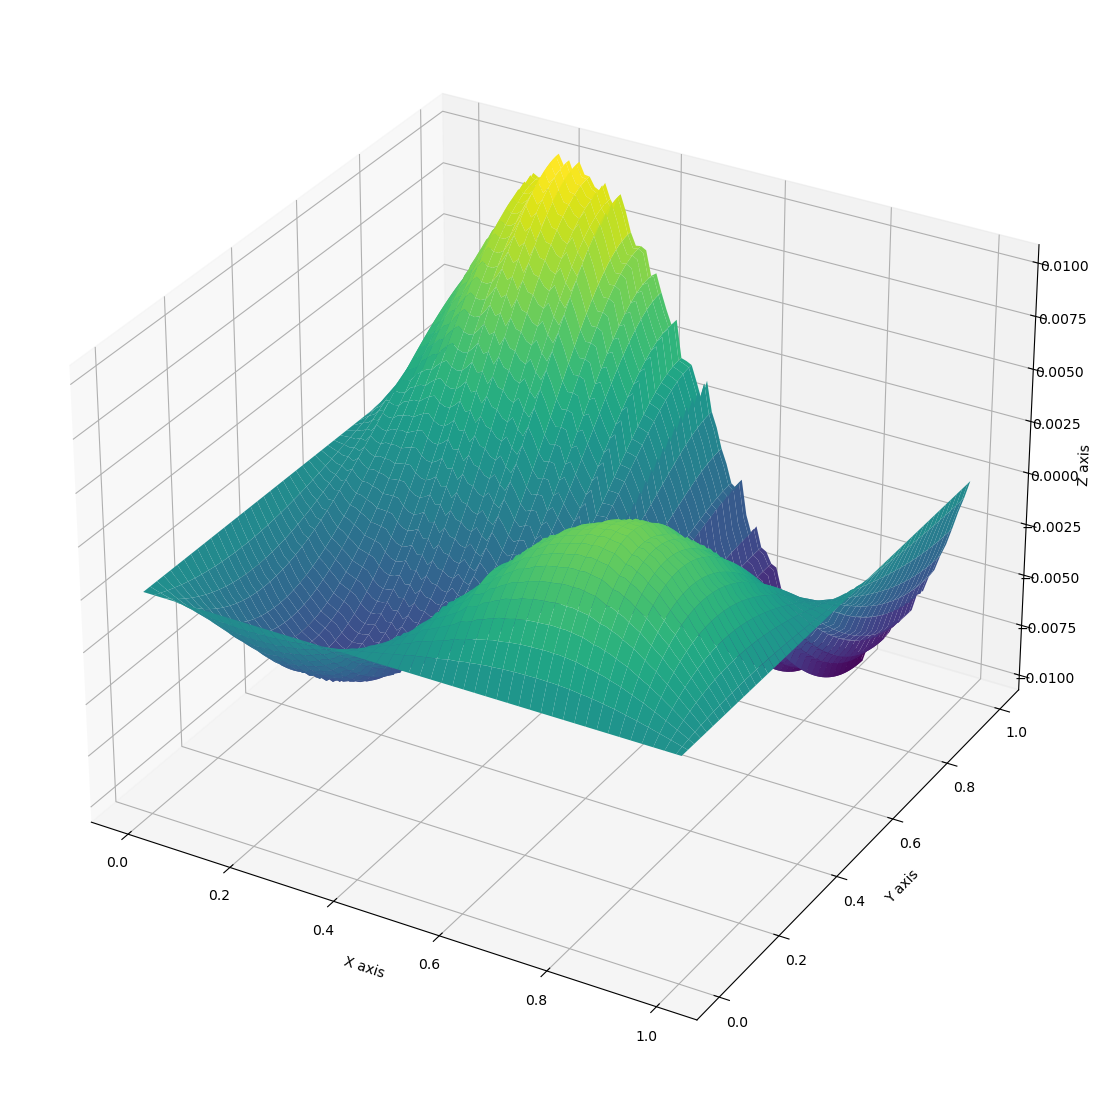

In [52]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
# print(x, y)

z = y**2 * np.sin(np.pi*x)
print(z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(x, y, z, cmap='viridis')

xy_pairs = torch.tensor(np.column_stack([x.ravel(), y.ravel()]), dtype = torch.float32)
# print((xy_pairs[0][0]))
h = 1e-3
dN_dy=lambda x,y:(N(x,y+1e-4)-N(x,y))/1e-4
x1 = xy_pairs[:, 0]
y1 = xy_pairs[:, 1]
def B(x, y):
    result = 2*y*torch.sin(torch.pi*x)
    return result
        
def trial_solution(x,y):
    result = B(x,y).squeeze()+ x *(1-x)*y*(N(x,y).squeeze()-N(x,torch.ones(y.shape)).squeeze()-dN_dy(x,torch.ones(y.shape)).squeeze())
    return result
z_trial = trial_solution(x1,y1).detach().numpy().reshape(100,100)
print(f"Maximum ABS error: {np.max(np.abs(z_trial-z))}")
print(z_trial.shape)
print(z.shape)

ax.plot_surface(x, y, z_trial-z, cmap='viridis')
# # Adding labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()